In [55]:
# importing libraries
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import sys
import math
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from numpy import newaxis

stock_name = 'AAPL'
stock_data = pdr.get_data_tiingo(stock_name, api_key='a11bde55bb2d6793161fd75a059757be89231ad2')
csv_name = 'Dataset/'+stock_name+'.csv'
stock_data.to_csv(csv_name)
#df = pd.read_csv(csv_name, parse_dates=True, usecols=['date', 'close'], na_values=['nan'])
prices_dataset =  pd.read_csv(csv_name, header=0)
prices_dataset.tail()
#df['date'] = (pd.to_datetime(df['date'])).astype('int64')/1000000000

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,AAPL,2020-07-24 00:00:00+00:00,370.46,371.8800,356.58,363.95,46359716,370.46,371.8800,356.58,363.95,46359716,0.0,1.0
1254,AAPL,2020-07-27 00:00:00+00:00,379.24,379.6200,373.92,374.84,30303548,379.24,379.6200,373.92,374.84,30303548,0.0,1.0
1255,AAPL,2020-07-28 00:00:00+00:00,373.01,378.1986,372.99,377.47,25906375,373.01,378.1986,372.99,377.47,25906375,0.0,1.0
1256,AAPL,2020-07-29 00:00:00+00:00,380.16,380.9200,374.85,375.00,22582314,380.16,380.9200,374.85,375.00,22582314,0.0,1.0
1257,AAPL,2020-07-30 00:00:00+00:00,384.76,385.1900,375.07,376.75,39532505,384.76,385.1900,375.07,376.75,39532505,0.0,1.0


In [56]:
prices = prices_dataset.close.values.astype('float32')
prices = prices.reshape(prices.shape[0], 1)
prices.shape
scaler = MinMaxScaler(feature_range=(0, 1))
prices = scaler.fit_transform(prices)
train_size = int(len(prices) * 0.80)
test_size = len(prices) - train_size
train, test = prices[0:train_size,:], prices[train_size:len(prices),:]
print(len(train), len(test))

1006 252


In [72]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
pd.options.mode.chained_assignment = None
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))
model.compile(loss='mse', optimizer='rmsprop')

model.fit(trainX, trainY, batch_size=128, epochs=10, validation_split=0.05)
# make predictions
#trainPredict = model.predict(trainX)
#testPredict = model.predict(testX)

c:\users\varun_bawa\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:25: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
c:\users\varun_bawa\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
c:\users\varun_bawa\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


Train on 953 samples, validate on 51 samples
Epoch 1/10
953/953 [==============================] - 3s 4ms/step - loss: 0.0374 - val_loss: 0.0652
Epoch 2/10
953/953 [==============================] - 0s 65us/step - loss: 0.0189 - val_loss: 0.0332
Epoch 3/10
953/953 [==============================] - 0s 62us/step - loss: 0.0115 - val_loss: 0.0178
Epoch 4/10
953/953 [==============================] - 0s 66us/step - loss: 0.0097 - val_loss: 0.0146
Epoch 5/10
953/953 [==============================] - 0s 72us/step - loss: 0.0085 - val_loss: 0.0122
Epoch 6/10
953/953 [==============================] - 0s 57us/step - loss: 0.0073 - val_loss: 0.0093
Epoch 7/10
953/953 [==============================] - 0s 73us/step - loss: 0.0058 - val_loss: 0.0063
Epoch 8/10
953/953 [==============================] - 0s 68us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 9/10
953/953 [==============================] - 0s 73us/step - loss: 0.0025 - val_loss: 0.0011
Epoch 10/10
953/953 [==========================

[[373.01]]
[[ 201.38194]
 [ 340.09506]
 [ 617.3433 ]
 [1228.4331 ]
 [2385.0942 ]]


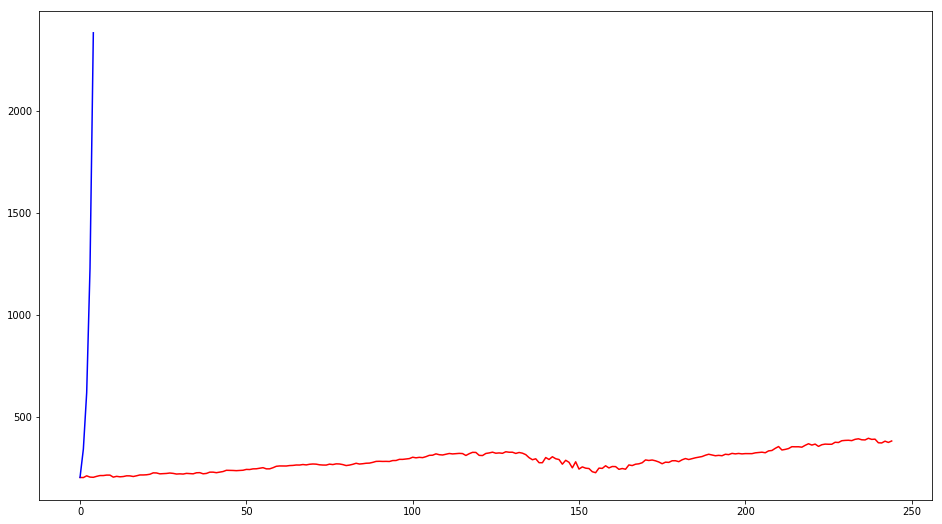

In [73]:
def plot_results_multiple(predicted_data, true_data, length):
    plt.plot(scaler.inverse_transform(true_data.reshape(-1, 1))[length:], 'r',  label='True Data')
    #plt.plot(scaler.inverse_transform(np.array(predicted_data).reshape(-1, 1))[length:], 'b',  label='Predicted Data')
    plt.plot(scaler.inverse_transform(np.array(predictions).reshape(-1, 1))[:length], 'b',  label='Predicted Data')
    plt.rcParams["figure.figsize"] = [16,9]
    #plt.show()
    
#predict lenght consecutive values from a real one
def predict_sequences_multiple(model, firstValue,length):
    prediction_seqs = []
    curr_frame = firstValue
    
    for i in range(length): 
        predicted = []        
        
        #print(model.predict(curr_frame[newaxis,:,:]))
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        
        curr_frame = curr_frame[0:]
        curr_frame = np.insert(curr_frame[0:], i+1, predicted[-1], axis=0)
        
        prediction_seqs.append(predicted[-1])
        
    return prediction_seqs

predict_length=5
predictions = predict_sequences_multiple(model, testX[0], predict_length)
print(scaler.inverse_transform(testX[-1]))
#print(np.array(predictions).reshape(-1, 1)[:predict_length])
print(scaler.inverse_transform(np.array(predictions).reshape(-1, 1)))
plot_results_multiple(predictions, testY, predict_length)